In [44]:
import pandas as pd
import glob
import json
import re
import numpy as np
from IPython.display import display

In [45]:
import os 
def extract_config(line):
    line = line.rstrip(')\n')
    config = re.findall("([a-zA-Z_0-9]+)='?([^,'()]*)'?", line)      
    #print(line)
    #print(config)
    return {k: v for k, v in config}             

def list_dict_reverse(L):
    """ Given a list of dict with identical keys, turn that into a dict of numpy arrays.
    """
    keys = L[0].keys()
    res = {}
    for k in keys:
        res[k] = np.asarray([l[k] for l in L])
    return res

set_fn = set()


def parse_log(fn):
    with open(fn, 'r') as f:
        cfg = extract_config(f.readline())
        train_logs, test_logs = [], []
        for line in f.readlines():
            try:
                parsed = json.loads(line)
            except json.JSONDecodeError:
                continue
            if parsed['mode'] == 'train':
                train_logs.append(parsed)
            elif parsed['mode'] == 'test':
                test_logs.append(parsed)
        train_logs = list_dict_reverse(train_logs)
        test_logs = list_dict_reverse(test_logs)
        return cfg, train_logs, test_logs
        
data = []
data_var = []
for fn in (glob.glob('../res_proto_1rV_adam/*') + glob.glob('../res_proto_1flat_adam/*') +
           glob.glob('../res_proto_1rNP_adam/*') + glob.glob('../res_proto_1flatNP_adam/*')
            ):
    if fn[-2:] == '_I' or fn[-5:] == '.json':
        continue
    print("Read", fn)
    if fn in set_fn:
        print("Already parsed", fn)
        continue
    set_fn.add(fn)
    try:
        cfg, tr, te = parse_log(fn)
    except:
        continue

    cfg.update({
        'final_length': te['length'][-1],
        'final_loss': te['loss_objs'][-1],
        'final_H1': te['entropy_1.0'][-1],
        'final_H2': te['entropy_2.0'][-1],
        'final_H3': te['entropy_3.0'][-1],

    })
    for k in te.keys():
        if k.startswith('length'):
            cfg.update({
                'init_' + k: te[k][0],
                'final_' + k: te[k][-1],
            })
            
    try:
        topsim_json = os.path.join(fn + '_I', 'topsim_1on1,sub2,norm.json')
        with open(topsim_json, 'r') as f:
            spearman = json.load(f)
            cfg['spearman'] = spearman['spearman']
            cfg['spearman_ctx'] = spearman['spearman_ctx']
    except Exception as e:
        pass
    try:
        compo_json = os.path.join(fn + '_I', 'compo_.json')
        with open(compo_json, 'r') as f:
            D = json.load(f)
            cfg['compo'] = D['sum_norm']
        print(cfg['compo', fn])
    except Exception as e:
        pass
    try:
        per_arg_H_msg_json = os.path.join(fn + '_I', 'per_arg_H_msg.json')
        with open(per_arg_H_msg_json, 'r') as f:
            D = json.load(f)
            cfg['avg_H'] = float(D['freq_weighted_avg_H'])
    except Exception as e:
        pass
    data_var.append(cfg)
df = pd.DataFrame(data_var)

df = df.apply(lambda x: pd.to_numeric(x, errors='ignore', downcast='float'))
df['flat_attention'] = df['flat_attention'].fillna('False')
df.columns
df = df[df['compo'] < 1.0]

Read ../res_proto_1rV_adam/f65c036b2115e7aaf339eb7bdf00fc5c
Read ../res_proto_1rV_adam/64a70f12ba1849524f77d59c72cfb023
Read ../res_proto_1rV_adam/6513a559c68a629f37a7eb3f027b8e87
Read ../res_proto_1rV_adam/802ac044d6c1026384597b7f692b24a3
Read ../res_proto_1rV_adam/fbd9e94f092f4af6cb61f129df6adf9d
Read ../res_proto_1rV_adam/ae06099131af124f9a45e77a7434de6d
Read ../res_proto_1rV_adam/35000b2492598476970f7ea1f29ee209
Read ../res_proto_1rV_adam/53553846f5bb5ea5a47436d2a47520a9
Read ../res_proto_1rV_adam/b13cf7711a3567808e31e7da02aa98e5
Read ../res_proto_1rV_adam/1d9e53ae7f0a93dc065eccdc77ecb787
Read ../res_proto_1rV_adam/a9118f8eda23b0830cf21c56e7b882b9
Read ../res_proto_1rV_adam/083b0bde824cc3007257000b834a31f3
Read ../res_proto_1rV_adam/6ba3754ca90fdfccf75dc1d570067314
Read ../res_proto_1rV_adam/3650fd66bb8f2094252ce3be42c2f898
Read ../res_proto_1rV_adam/58cf2da2017d68f5fb7d7a5ef1e0bd13
Read ../res_proto_1rV_adam/a138982bfb8fb29299182fdf7db154a6
Read ../res_proto_1rV_adam/05d6c45a14e5b

# Regression

In [53]:
import statsmodels.api as sm

#data = df[(df['final_loss'] < 12.0) & (~ df['spearman'].isna())]# & (df['flat_attention'] == 'False')]
#data = df[(df['final_loss'] < 12.0)]# & (~ df['spearman'].isna())]# & (df['flat_attention'] == 'False')]
data = df
data['ada_len_dummy'] = data['ada_len_cost_thresh'].replace(0.0, 20)

data['flat_attention_dummy'] = (data['flat_attention'] == 'True').astype(float)
data['penalty_dummy'] = (data['length_cost'] == 0.0).astype(float)
data['beta2'] = np.log(data['adam_beta2'])
data['snl2'] = (data['sender_nlayers'] >= 2).astype(float)
data['snl3'] = (data['sender_nlayers'] >= 3).astype(float)
data['snl4'] = (data['sender_nlayers'] >= 4).astype(float)
data['rnl2'] = (data['receiver_nlayers'] >= 2).astype(float)
data['rnl3'] = (data['receiver_nlayers'] >= 3).astype(float)
data['rnl4'] = (data['receiver_nlayers'] >= 4).astype(float)
X = data[[#'sender_nlayers', 'receiver_nlayers', 'sender_hidden',
          #'temperature', 
         #'penalty_dummy', 'ada_len_dummy',
        'snl2', 'snl3', 'snl4',
         'rnl2', 'rnl3', 'rnl4',
         'final_H1', #'final_H2', 'final_H3',
        'final_loss',
        'final_length', 
        'flat_attention_dummy'
         ]].values
X = sm.add_constant(X)
#print(X)
y = data['compo'].values
#print(X.shape, y.shape)
model = sm.OLS(y, X)
res = model.fit(cov_type='HC0')
print(res.summary()), 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     16.10
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           2.26e-17
Time:                        16:50:22   Log-Likelihood:                 191.81
No. Observations:                 119   AIC:                            -361.6
Df Residuals:                     108   BIC:                            -331.1
Df Model:                          10                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1558      0.124      1.259      0.2

(None,)

# Linearity

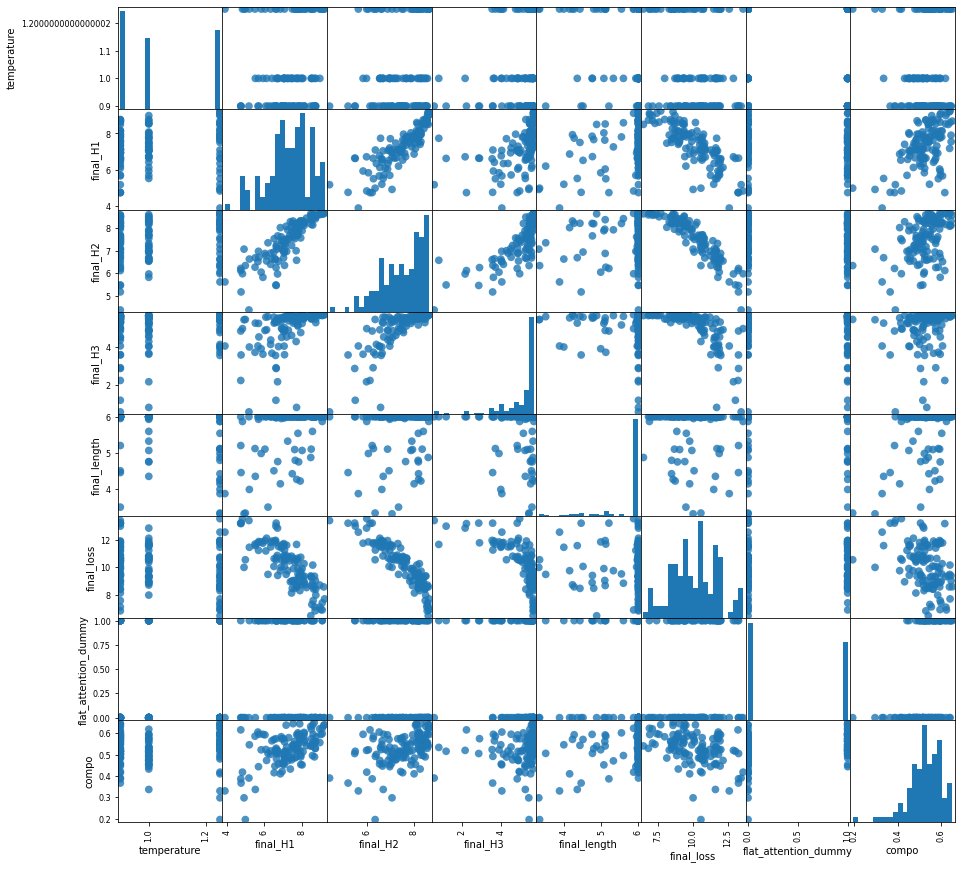

In [24]:
df['ada_len_dummy'] = df['ada_len_cost_thresh'].replace(0.0, 20)
df['C'] = df['ada_len_dummy']*df['length_cost']

#'spearman', 'spearman_ctx', 
#, 'H0', 'H10', 'H50', 'H500', 'H10000'
P = pd.plotting.scatter_matrix(
    #df[['sender_nlayers', 'receiver_nlayers', 'final_length', 'sender_hidden', 'final_loss', 'C', 'compo', 'avg_H']],
    df[['temperature', 'final_H1', 'final_H2', 'final_H3', 'final_length', 'final_loss', 'flat_attention_dummy', 'compo']],
    figsize=(15, 15), marker='o',
    hist_kwds={'bins': 20}, s=60, alpha=.8
)

# Residual analysis

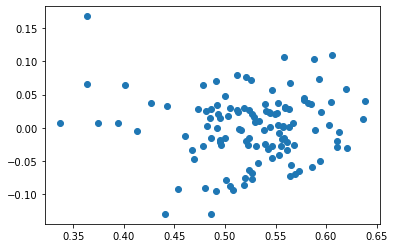

In [48]:
import matplotlib.pyplot as plt 
plt.scatter(res.predict(X), res.predict(X) - y)

## Regression on topsim

In [26]:
import statsmodels.api as sm

#data = df[(df['final_loss'] < 11.5)]# & (~ df['avg_H'].isna())]# & (df['flat_attention'] == 'False')]
#data = df[(df['final_loss'] < 12.0) & (~ df['spearman'].isna()) &
#          (df['receiver_nlayers'] <= 2.0) & (df['sender_nlayers'] >= 3.0)]

data = df
data['flat_attention_dummy'] = (data['flat_attention'] == 'True').astype(float)
data['penalty_dummy'] = (data['length_cost'] == 0.0).astype(float)
data['ada_len_dummy'] = (data['ada_len_cost_thresh'].replace(0.0, 20) * data['penalty_dummy'])

data['beta2'] = np.log(data['adam_beta2'])
data['snl2'] = (data['sender_nlayers'] >= 2).astype(float)
data['snl3'] = (data['sender_nlayers'] >= 3).astype(float)
data['snl4'] = (data['sender_nlayers'] >= 4).astype(float)
data['rnl2'] = (data['receiver_nlayers'] >= 2).astype(float)
data['rnl3'] = (data['receiver_nlayers'] >= 3).astype(float)
data['rnl4'] = (data['receiver_nlayers'] >= 4).astype(float)
data['sender_hidden_d'] = (data['sender_hidden'] > 300).astype(float)
data['C'] = data['ada_len_dummy']*data['length_cost']

data['spearman_ctx_abs'] = np.abs(data['spearman_ctx'])
data['spearman_m_ctx'] = data['spearman'] - data['spearman_ctx_abs']

X = data[[#'temperature', 'beta2', 
         #'sender_hidden_d',
         #'snl2', 'snl3', 'snl4',
         #'rnl2', 'rnl3', 'rnl4',
         'final_H1', 'final_H2', 'final_H3',
        #'penalty_dummy', 
        #'ada_len_dummy',
        #'C',
        'final_loss', 
        'final_length', 
        'flat_attention_dummy'
         ]].values
X = sm.add_constant(X)
#print(X.shape)
#print(X)
y = data['avg_H'].values
#print(X.shape, y.shape)
model = sm.OLS(y, X)
res = model.fit(cov_type='HC0')
print(res.summary()), 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     47.05
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           2.12e-28
Time:                        20:43:41   Log-Likelihood:                 41.728
No. Observations:                 119   AIC:                            -69.46
Df Residuals:                     112   BIC:                            -50.00
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7649      0.577     -3.058      0.0

(None,)

## Effect on loss?

In [39]:
import statsmodels.api as sm

data = df[(df['final_loss'] < 12) & (~ df['spearman'].isna())]# & (df['flat_attention'] == 'False')]
#data = df[(df['final_loss'] < 12.0) & (~ df['spearman'].isna()) &
#          (df['receiver_nlayers'] <= 2.0) & (df['sender_nlayers'] >= 3.0)]

data['ada_len_dummy'] = data['ada_len_cost_thresh'].replace(0.0, 20)

data['flat_attention_dummy'] = (data['flat_attention'] == 'True').astype(float)
data['penalty_dummy'] = (data['length_cost'] == 0.0).astype(float)
data['beta2'] = np.log(data['adam_beta2'])
data['snl2'] = (data['sender_nlayers'] >= 2).astype(float)
data['snl3'] = (data['sender_nlayers'] >= 3).astype(float)
data['snl4'] = (data['sender_nlayers'] >= 4).astype(float)
data['rnl2'] = (data['receiver_nlayers'] >= 2).astype(float)
data['rnl3'] = (data['receiver_nlayers'] >= 3).astype(float)
data['rnl4'] = (data['receiver_nlayers'] >= 4).astype(float)
data['sender_hidden_d'] = (data['sender_hidden'] < 300).astype(float)
data['C'] = data['ada_len_dummy']*data['length_cost']

data['spearman_ctx_abs'] = np.abs(data['spearman_ctx'])
data['spearman_m_ctx'] = data['spearman'] - data['spearman_ctx_abs']

X = data[['temperature', 'sender_hidden_d',
         'snl2', 'snl3', 'snl4',
         'rnl2', 'rnl3', 'rnl4',
        'final_H1', 'final_H2', 'final_H3',
        'final_length', 
        'flat_attention_dummy'
         ]].values
X = sm.add_constant(X)
#print(X.shape)
#print(X)
y = data['final_loss'].values
#print(X.shape, y.shape)
model = sm.OLS(y, X)
res = model.fit(cov_type="HC0")
print(res.summary()), 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     76.90
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           1.92e-44
Time:                        20:47:38   Log-Likelihood:                -68.585
No. Observations:                 109   AIC:                             165.2
Df Residuals:                      95   BIC:                             202.8
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8683      0.775     24.355      0.0

/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

(None,)

# Factors

119
6


final_loss                 final_length  \
                                         mean       std count         mean   
flat_attention ada_len_cost_thresh                                           
False          0.0                   9.731642  1.361268    36     5.999941   
               5.0                   9.813005  1.695740    12     5.473765   
               10.0                 10.478140  2.107671    18     5.191714   
True           0.0                  10.650350  1.523408    26     5.997261   
               5.0                  10.192038  1.677887    12     5.642391   
               10.0                  9.890728  1.530093    15     5.226116   

                                                       compo                  \
                                         std count      mean       std count   
flat_attention ada_len_cost_thresh                                             
False          0.0                  0.000262    36  0.516566  0.048585    36   
               5.0                  0.632377    12  0.523627  0.082011    12   
               10.0                 1.020410    18  0.444482  0.113026    18   
True           0.0                  0.013968    26  0.555127  0.050865    26   
               5.0                  0.531238    12  0.568918  0.057196    12   
               10.0                 0.863272    15  0.564472  0.043064    15   

                                        lr  ...       random_seed            \
                                      mean  ... count        mean       std   
flat_attention ada_len_cost_thresh          ...                               
False          0.0                  0.0003  ...    36    1.333333  1.218899   
               5.0                  0.0003  ...    12    2.083333  1.083625   
               10.0                 0.0003  ...    18    1.333333  1.236694   
True           0.0                  0.0003  ...    26    1.461538  1.240347   
               5.0                  0.0003  ...    12    2.083333  1.083625   
               10.0                 0.0003  ...    15    1.333333  1.175139   

                                         adam_beta2                  \
                                   count       mean       std count   
flat_attention ada_len_cost_thresh                                    
False          0.0                    36   0.968250  0.043102    36   
               5.0                    12   0.968250  0.041236    12   
               10.0                   18   0.973000  0.040354    18   
True           0.0                    26   0.965423  0.044643    26   
               5.0                    12   0.969000  0.041746    12   
               10.0                   15   0.963000  0.046268    15   

                                   temperature                  
                                          mean       std count  
flat_attention ada_len_cost_thresh                              
False          0.0                    1.008333  0.138099    36  
               5.0                    1.079167  0.155882    12  
               10.0                   1.083333  0.158114    18  
True           0.0                    0.990385  0.135661    26  
               5.0                    1.079167  0.155882    12  
               10.0                   1.090000  0.159463    15  

[6 rows x 21 columns]

<AxesSubplot:xlabel='final_length', ylabel='compo'>

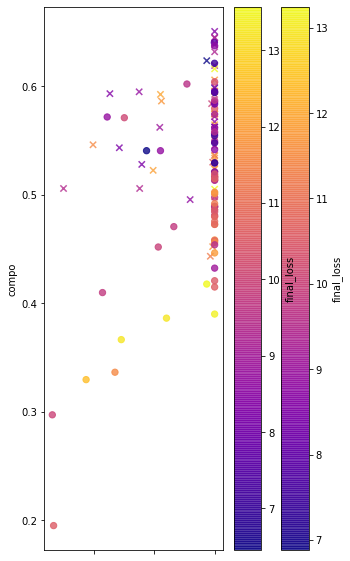

In [42]:
metric = 'compo'

fields = ['final_loss', 'final_length', metric, 'lr', 'random_seed',
          'adam_beta2', 'ada_len_cost_thresh', 'flat_attention', 'optimizer', 'temperature']

criterion_1 = (df['mode'] == 'gs')
# criterion_2 = (df['optimizer'] == 'adam')
#criterion_3 = (df['train_test_ratio'] == '-1.0')
print(len(df.loc[criterion_1]))
a = df.loc[criterion_1][fields].groupby(['flat_attention',  'ada_len_cost_thresh'])
print(len(a))
print(a)
display(a.agg(['mean', 'std', 'count']))
df['size'] = df['sender_nlayers']*df['receiver_nlayers'] *10

ax = df.loc[df['flat_attention'] == 'True'].plot.scatter(x = 'final_length', y = metric, c='final_loss',
                    s = 40, marker='x',
                    alpha=0.8, colormap='plasma', figsize=(5,10));
df.loc[df['flat_attention'] == 'False'].plot.scatter(x = 'final_length', y = metric, c='final_loss',
                    s = 40, marker='o',
                    alpha=0.8, colormap='plasma', ax=ax, sharex=True, sharey=True)

<AxesSubplot:xlabel='final_loss', ylabel='compo'>

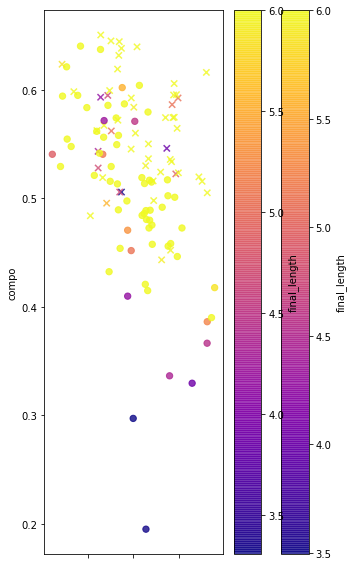

In [43]:

#plt.figure()
ax = df.loc[df['flat_attention'] == 'True'].plot.scatter(x = 'final_loss', y = metric, c='final_length',
                    s = 40, marker='x',
                    alpha=0.8, colormap='plasma', figsize=(5,10))
df.loc[df['flat_attention'] == 'False'].plot.scatter(x = 'final_loss', y = metric, c='final_length',
                    s = 40, marker='o',
                    alpha=0.8, colormap='plasma', ax=ax, sharex=True, sharey=True)

### Does flat attention help for final loss too?

In [247]:
import statsmodels.api as sm

data = df[df['final_loss'] < 10.0]
data['flat_attention_dummy'] = (data['flat_attention'] == 'True').astype(float)
data['penalty_dummy'] = (data['length_cost'] == 0.0).astype(float)
data['beta2'] = np.log(data['adam_beta2'])
X = data[['beta2', 'sender_nlayers', 'receiver_nlayers',
        'final_length', 
        'length_cost', 'ada_len_cost_thresh',
       'flat_attention_dummy']].values
X = sm.add_constant(X)
#print(X)
y = data['final_loss'].values
#print(X.shape, y.shape)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary()), 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2.690
Date:                Thu, 01 Jul 2021   Prob (F-statistic):             0.0193
Time:                        12:43:53   Log-Likelihood:                -64.911
No. Observations:                  57   AIC:                             145.8
Df Residuals:                      49   BIC:                             162.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3007      1.961      6.272      0.0

/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/media/Docs/miniconda3/envs/egg/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

(None,)

# Checking assumptions
First, let's see if residuals are normally distributed.

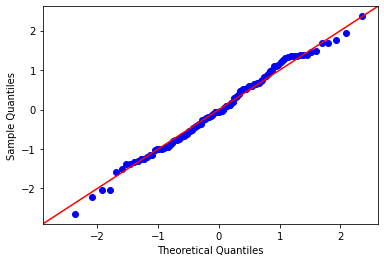

In [930]:
fig = sm.qqplot(res.resid, fit=True, line="45")

What about variance?